In [4]:
%matplotlib inline

from IPython.core.magic import register_line_magic
                                
import matplotlib.pyplot as plt

from annoy import AnnoyIndex
from fastai.vision import ConvLearner 
from fastai import vision
import fastai
from torchsummary import summary

from PIL import Image
import requests


from fastai import torch_core

import torchvision.models as tvm
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch

import cv2
import glob
import numpy as np
import os

In [2]:
DATA_PATH = './data/'
TRANSFORMATION_PARAMS = dict(
    size=224, 
    padding_mode="zeros"
)

# Introduction
installation ![][img-overview]

[img-overview]: https://i.imgur.com/xLtNhLp.png

# Data Preparation
TODO: where should one download data or training images?

In [5]:
DATA_PATH = './data/'
TRANSFORMATION_PARAMS = dict(
    size=224, 
    padding_mode="zeros"
)

In [6]:
# This class is responsible for transforming images (aka. preprocessing)
# before being feed to a neural network
class ImageDataset(Dataset):
    def __init__(self, root_dir):
        # Look for jpegs in the directory
        self.image_paths = glob.glob(root_dir + '*.jpeg')
        assert self.image_paths != 0, "No images found in {}".format(root_dir)

        self.image_names = [os.path.basename(path) for path in self.image_paths]
        _, self.tfms = vision.get_transforms()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index, with_transformation=True):
        image_path = self.image_paths[index]
        
        # Returns image in RGB format; each pixel ranges between 0.0 and 1.0
        image = vision.open_image(image_path)

        if not with_transformation:
            return image.px

        # Apply transforms to the image        
        return self.transform(self.tfms, image).px
    
    def transform(self, tfms, img):
        return vision.apply_tfms(tfms, img, **TRANSFORMATION_PARAMS)
    
    def get(self, index, **kwargs):
        return self.__getitem__(index, **kwargs)

In [7]:
dataset = ImageDataset(DATA_PATH)

In [8]:
dataset.get(0).shape

torch.Size([3, 224, 224])

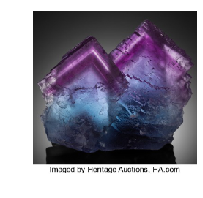

In [9]:
vision.image._show_image(dataset.get(0))

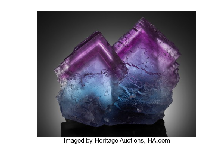

In [10]:
vision.image._show_image(dataset.get(0, with_transformation=False))

# Feature Representation Computation
In this part, we will use a pretrained model to compute a dense feature representation of training images. This features will be used in a later process finding similar images. First, we will download the pretrained model (VGG16), then compute the dense features of 4096 (from ReLU-36).

In [12]:
# load a pretrained VGG16
model = tvm.vgg16(pretrained=True)

In [9]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [13]:
def forward_pass(model, batch):
    layer_relu_36 = model.classifier[:4]
    
    feature_output = model.features.forward(batch)
    feature_output = feature_output.view(feature_output.size(0), -1)

    return layer_relu_36.forward(feature_output)


def compute_features(model, dataset, batch_size=16, test=False):
    features_list = []
    data_loader = DataLoader(dataset, batch_size=batch_size)
    
    # Compute features for all images
    count = 0
    for batch in data_loader:
        if count % 10 == 0:
            print('Batch %d' % count)


        output = forward_pass(model, batch)

        features_list.append(output.detach().numpy())
        if test:
            break
        count = count + 1
        
    features = np.vstack(features_list)
    return features

In [15]:
# This will take some time to run.
img_features = compute_features(model, dataset, test=False)
img_features.shape

Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Batch 50
Batch 60
Batch 70
Batch 80
Batch 90
Batch 100
Batch 110


(1843, 4096)

In [17]:
np.save('vgg_features', img_features)

# Nearest Neighbor Search
In the following, we will use the dense features that we just computed to build an index. This index is constructed specficially by Annoy that provides a quick retrieval of similar images given a query image. 

In [21]:
def construct_ann_index(metric, num_trees, features):
    feature_dims = features[0].shape[0]
    ann = AnnoyIndex(feature_dims, metric=metric)
    for index, feature in enumerate(features):
        ann.add_item(index, feature)

    ann.build(num_trees)
    return ann

ann = construct_ann_index('angular', 50, img_features)

In [22]:
# save for later use
ann.save('vgg_ann')

True

## Load training images' features and the built index to memory

In [23]:
# img_features = np.load('vgg_features.npy')
# ann = AnnoyIndex(img_features.shape[1], metric='angular').load('vgg_ann')
# ann.get_n_items()

## Exploration!
Now we have all necessary components to start exploring the result. We will first use some training images as query images. Secondly, we will develop a function that fetches an image from a url, and use that image as a query image. 

### Similar images of a training image

In [24]:
def find_similar_images(data_idx, nn=5):
    vision.image._show_image(dataset.get(data_idx))

    axies = plt.subplots(1, nn, figsize=(2*nn,2))[1]
    similar_images = ann.get_nns_by_item(data_idx, nn+1)[1:]
    
    print('Visually similar images` indices : %s' % ','.join(map(str, similar_images)))
    
    for i, tt in enumerate(zip(axies, similar_images)):
        ax, idx = tt
        vision.image._show_image(dataset.get(idx), ax=ax)
    
def find_similar_images_with_name(path):
    idx = None
    for i, t in enumerate(dataset.image_paths):
        if path in t:
            idx = i 
            break

    find_similar_images(idx)

Visually similar images` indices : 63,1573,349,859,1841


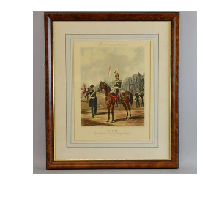

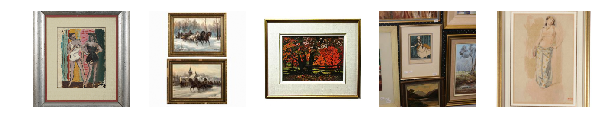

In [25]:
find_similar_images_with_name('0002247937625d20cd8564d8ff6e1cb2')

Visually similar images` indices : 741,1589,795,1516,926


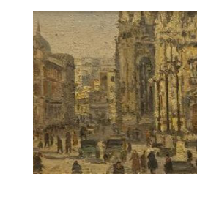

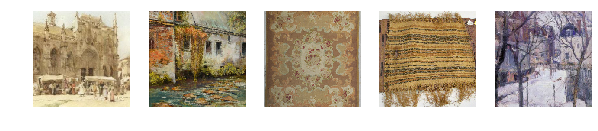

In [26]:
find_similar_images_with_name('000220799210e25dd5a9cd9e5fb43cdf')

Visually similar images` indices : 1788,1777,1418,1107,175


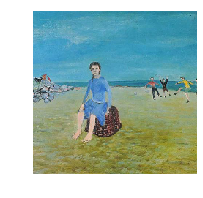

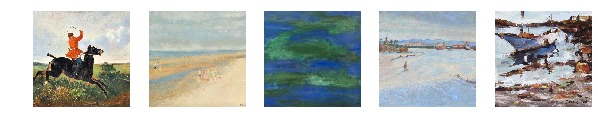

In [27]:
find_similar_images_with_name('000048159228ae35337d5d728d957051')

Visually similar images` indices : 1507,471,1287,1775,1206


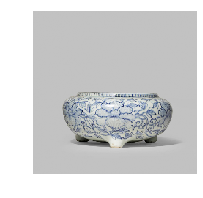

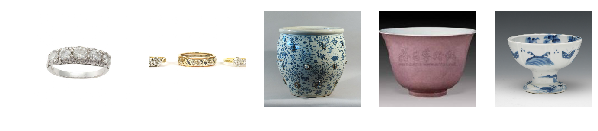

In [28]:
find_similar_images_with_name('000231053689bac7c3952d9f497aa19d')

Visually similar images` indices : 1525,200,1132,19,685


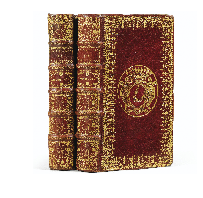

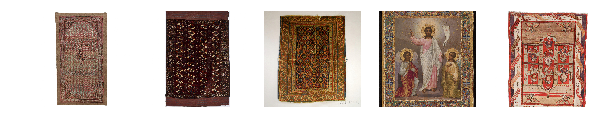

In [29]:
find_similar_images_with_name('000090035525211fe7aebd2a1d90f2d9')

Visually similar images` indices : 220,337,233,88,270


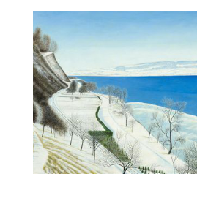

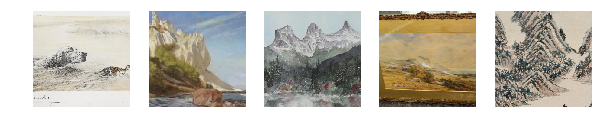

In [30]:
find_similar_images_with_name('00032418000077aa86bcd059cffe7233')

Visually similar images` indices : 587,1703,1423,769,528


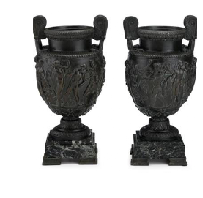

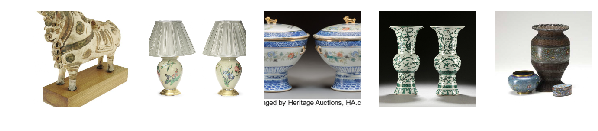

In [31]:
find_similar_images_with_name('0002549596329e6815fed38521b05c04')

Visually similar images` indices : 87,490,945,1594,97


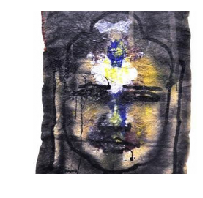

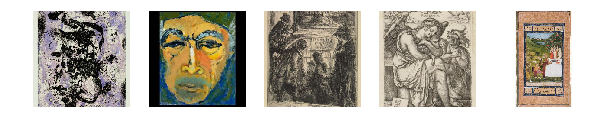

In [32]:
find_similar_images_with_name('00030933939637d4197a70f5ee72d5e5')

### Similar images of a image from the Internet

In [34]:
def retrieve_img(url):
    response = requests.get(url, stream=True)
    img = Image.open(response.raw)
    dd = np.transpose(np.asarray(img), (2, 0, 1)) / 255.0

    dd = torch.from_numpy(dd)

    dd = dd.type('torch.FloatTensor') 
    return vision.image.Image(dd)

url = 'https://www.moma.org/media/W1siZiIsIjcwNjE5Il0sWyJwIiwiY29udmVydCIsIi1yZXNpemUgMjAwMHgyMDAwXHUwMDNlIl1d.jpg?sha=399e17834add4eac'
img = retrieve_img(url)
img.shape

torch.Size([3, 1992, 2000])

In [35]:
# def forward_pass(img):

#     img = dataset.transform(dataset.tfms, img)
#     img4d = img.px.view(1, img.px.size(0), img.px.size(1), img.px.size(2))
#     feature_output = model.features.forward(img4d)
#     feature_output = feature_output.view(feature_output.size(0), -1)

#     output = model.classifier[:4].forward(feature_output)

#     return img, output.detach().numpy().reshape(-1)
# rr = forward_pass(img2)

In [37]:
# ann.get_nns_by_vector(rr[.detach().numpy().reshape(-1)], 5)

URL: https://www.moma.org/media/W1siZiIsIjcwNjE5Il0sWyJwIiwiY29udmVydCIsIi1yZXNpemUgMjAwMHgyMDAwXHUwMDNlIl1d.jpg?sha=399e17834add4eac
[179, 490, 40, 744, 752]


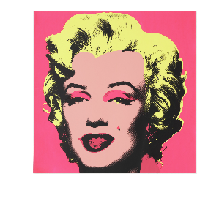

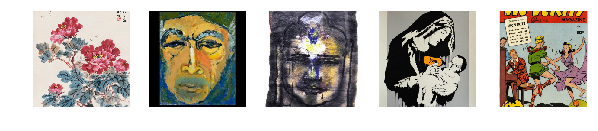

In [40]:
@register_line_magic
def show_sims(line):
    similar_images_of_url(line)
                                
def similar_images_of_url(url, nn=5):
    img = retrieve_img(url)
    img = dataset.transform(dataset.tfms, img)
    img4d = img.px.view(1, img.px.size(0), img.px.size(1), img.px.size(2))
    
    features = forward_pass(model, img4d).detach().numpy().reshape(-1)
    vision.image._show_image(img)


    axies = plt.subplots(1, nn, figsize=(2*nn,2))[1]
    similar_images = ann.get_nns_by_vector(features, nn+1)[1:]
    print('URL: %s' % url)
    print(similar_images)
    for i, tt in enumerate(zip(axies, similar_images)):
        ax, idx = tt
        vision.image._show_image(dataset.get(idx), ax=ax)
    
similar_images_of_url(url)

URL: https://thumbs-prod.si-cdn.com/dRPLYz_rZM7BKezMum2Zxro6XbI=/800x600/filters:no_upscale():focal(276x253:277x254)/https://public-media.smithsonianmag.com/filer/19/08/19082b9b-932c-4f8e-9ff6-5f3f2353a6e9/mona_lisa.jpg
[1023, 241, 1783, 1237, 509]


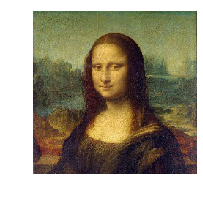

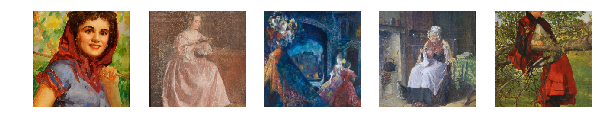

In [41]:
%show_sims https://thumbs-prod.si-cdn.com/dRPLYz_rZM7BKezMum2Zxro6XbI=/800x600/filters:no_upscale():focal(276x253:277x254)/https://public-media.smithsonianmag.com/filer/19/08/19082b9b-932c-4f8e-9ff6-5f3f2353a6e9/mona_lisa.jpg

URL: http://www.arte.it/foto/600x450/bd/10752-120221608.jpg
[1212, 1018, 1544, 723, 270]


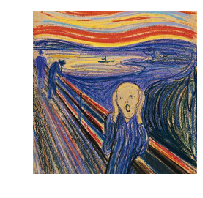

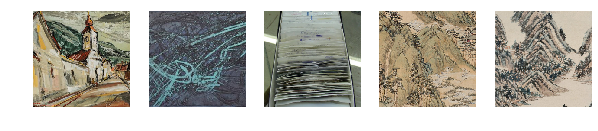

In [42]:
%show_sims http://www.arte.it/foto/600x450/bd/10752-120221608.jpg

URL: https://s.hswstatic.com/gif/vincent-van-gogh-paintings-from-saint-remy-2.jpg
[1439, 945, 364, 1536, 1236]


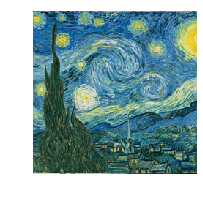

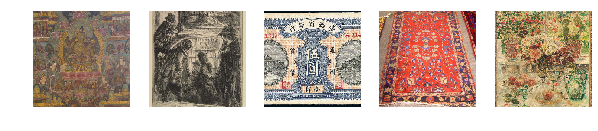

In [43]:
%show_sims https://s.hswstatic.com/gif/vincent-van-gogh-paintings-from-saint-remy-2.jpg

URL: http://americanthings.files.wordpress.com/2010/09/andy-vladimir-gorsky-loganfineartsdotcom.jpg
[744, 1044, 275, 681, 936]


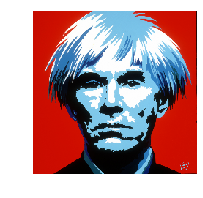

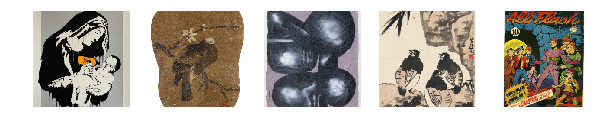

In [44]:
%show_sims http://americanthings.files.wordpress.com/2010/09/andy-vladimir-gorsky-loganfineartsdotcom.jpg

URL: https://dg19s6hp6ufoh.cloudfront.net/pictures/612888897/large/photo.jpeg?1452490446
[170, 1366, 1380, 292, 951]


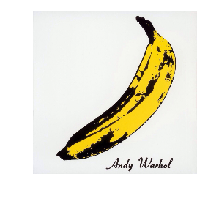

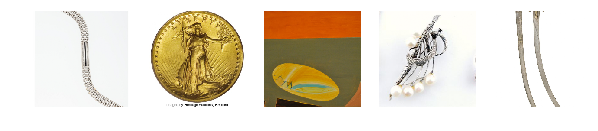

In [45]:
%show_sims https://dg19s6hp6ufoh.cloudfront.net/pictures/612888897/large/photo.jpeg?1452490446

URL: https://upload.wikimedia.org/wikipedia/commons/thumb/2/23/US_one_dollar_bill%2C_obverse%2C_series_2009.jpg/1200px-US_one_dollar_bill%2C_obverse%2C_series_2009.jpg
[519, 1738, 732, 1147, 387]


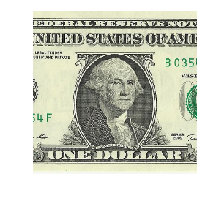

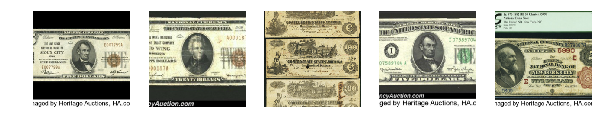

In [46]:
%show_sims https://upload.wikimedia.org/wikipedia/commons/thumb/2/23/US_one_dollar_bill%2C_obverse%2C_series_2009.jpg/1200px-US_one_dollar_bill%2C_obverse%2C_series_2009.jpg

URL: https://www.karatemart.com/images/products/large/hooked-badlands-sword-9977062.jpg
[1004, 257, 292, 1180, 1473]


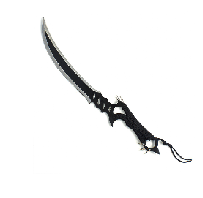

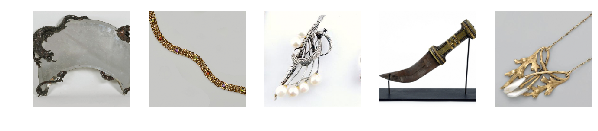

In [47]:
%show_sims https://www.karatemart.com/images/products/large/hooked-badlands-sword-9977062.jpg

URL: https://cdn.notonthehighstreet.com/fs/91/f6/0745-191d-4609-bfde-7df5bf1a693d/original_personalised-alisanne-birthstone-bracelet.jpg
[796, 566, 940, 1687, 430]


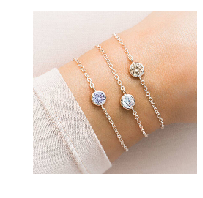

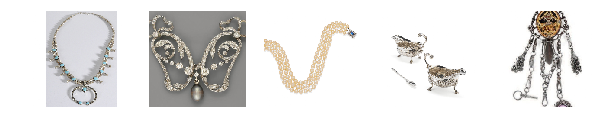

In [48]:
%show_sims https://cdn.notonthehighstreet.com/fs/91/f6/0745-191d-4609-bfde-7df5bf1a693d/original_personalised-alisanne-birthstone-bracelet.jpg

URL: https://media.glamour.com/photos/5994b4d573e5c76b06a020ca/master/w_644,c_limit/scar-mufasa.JPG
[1269, 1143, 1632, 404, 1177]


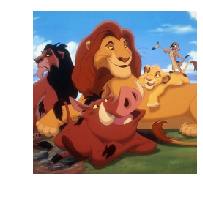

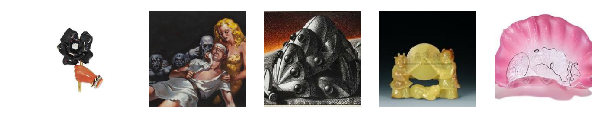

In [49]:
%show_sims https://media.glamour.com/photos/5994b4d573e5c76b06a020ca/master/w_644,c_limit/scar-mufasa.JPG

URL: https://assets.saatchiart.com/saatchi/462428/art/2917412/1987305-SVIUGTDS-7.jpg
[1018, 99, 270, 1837, 1213]


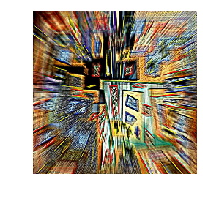

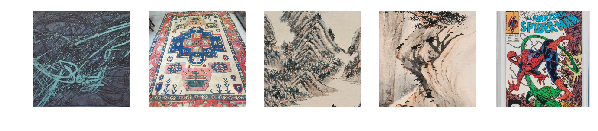

In [50]:
%show_sims https://assets.saatchiart.com/saatchi/462428/art/2917412/1987305-SVIUGTDS-7.jpg

URL: https://cdn.shopify.com/s/files/1/0668/2853/products/WARRIORS_6_5_news.jpg?v=1497311341
[1698, 1486, 1204, 669, 1482]


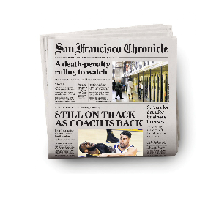

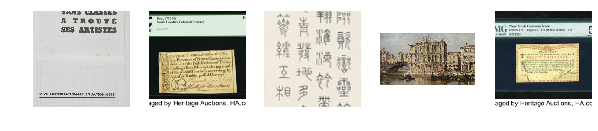

In [51]:
%show_sims https://cdn.shopify.com/s/files/1/0668/2853/products/WARRIORS_6_5_news.jpg?v=1497311341

URL: https://assets.bwbx.io/images/users/iqjWHBFdfxIU/iXEPdRCZNjmM/v0/-1x-1.jpg
[553, 548, 172, 1237, 1811]


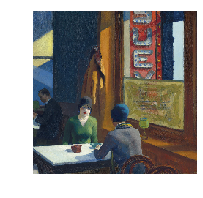

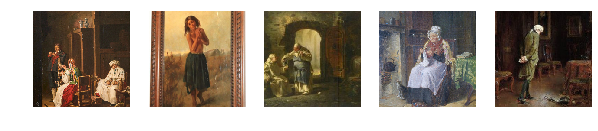

In [52]:
%show_sims https://assets.bwbx.io/images/users/iqjWHBFdfxIU/iXEPdRCZNjmM/v0/-1x-1.jpg